In [1]:
import StatsBase
using DataFrames, Gadfly, CSV, Flux, Cairo

function reysum(xs, ys)
    local area = 0
    for i=2:length(xs)
        dx = abs(xs[i] - xs[i-1])
        y = (ys[i] + ys[i-1])/2
        area += dx*y
    end
    return round(area, digits=2)
end

┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /home/akako/.julia/packages/Gadfly/09PWZ/src/mapping.jl:228


reysum (generic function with 1 method)

In [2]:
df = CSV.File("./data_fourtop.csv") |> DataFrame
# shuffle
df = df[StatsBase.shuffle(1:size(df, 1)),:]
first(df,3)

,Column1,signal,weight,htb,nbtags,njets,nleps,ptj1,ptj7,ptl1,ptl2,ptl3,q1
,Int64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰,Float64⍰
1,65555,0.0,0.0060509,291.523,1.0,5.0,2.0,291.523,0.0,24.991,19.262,-1.0,1.0
2,1185,0.0,0.00201721,126.932,2.0,2.0,2.0,210.066,0.0,96.0275,27.3499,-1.0,1.0
3,5583,0.0,0.0010017,131.4,2.0,5.0,2.0,103.718,0.0,138.597,20.7186,-1.0,1.0


## Data Inspection
First, let's inspect the data to get a feeling of it. From the plots below, we see that there are some
separation in nbtags and njets, this is, for sure, because of the physics: our signals are 4-tops and thus we have a bunch of b-quarks coming from the decay.

### About Weights
From the weight plot we know we're screwed no matter what: the signal has tiny weights, meaning unless we can isolate signal from background completely, the final distribution yield is bound to be *terrible* regardless of our model's performance.

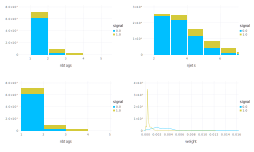

In [3]:
histnb = plot(df, x=:nbtags, color=:signal, Geom.histogram, style(bar_spacing=1mm),Coord.cartesian(xmin=0.5, xmax=5.5),Scale.color_discrete_hue)
histnjets = plot(df, x=:njets, color=:signal, Geom.histogram, style(bar_spacing=1mm), Coord.cartesian(xmin=1.5, xmax=7),Scale.color_discrete_hue)
histnb_density = plot(df, x=:nbtags, color=:signal, Geom.histogram, Coord.cartesian(xmin=1, xmax=5),Scale.color_discrete_hue)
histnweights = plot(df, x=:weight, color=:signal,Geom.density(), Coord.cartesian(xmin=0, xmax=0.016),Scale.color_discrete_hue)

set_default_plot_size(10inch, 6inch)
gridstack([histnb histnjets; histnb_density histnweights])

## Data Preparation

We want to sort our data into the form: ( (parameters, signal or not),  .... ). So that we can loop through this matrix, and feed first element to predict(x), and use the signal as loss.

Also, we want to **shuffle** (we don't know if it was originally ordered or not), and **separate** them into 2 piles, for validation (underfit? overfit?))

In [4]:
# 80% train
# 20% test
df_train = df[1:round(Int, size(df,1)*0.8),:]
df_test = df[round(Int,size(df,1)*0.8+1):end,:]

# re-balance train set, match length of signals
df_balanced = df_train[df_train.signal .== 1.0,:]
bkg_rows = df_train[df_train.signal .== 0.0,:]
bkg_rows = bkg_rows[1:size(df_balanced,1),:]
append!(df_balanced, bkg_rows);

In [5]:
# shuffle
df_balanced = df_balanced[StatsBase.shuffle(1:size(df_balanced, 1)),:]

xs_train = convert(Matrix, df_balanced[1:end,4:13])
ys_train = df_balanced.signal
xs_test = convert(Matrix, df_balanced[1:end,4:13])
ys_test = df_balanced.signal

# make the tag one-hot
ys_train = [Flux.onehot(i, [1,0]) for i in ys_train]
# zip xs_train and ys_train together
data = collect(zip(eachrow(xs_train), ys_train));

## Single layer network
#### Ignoreing weight for now. We can use weight when plotting the final yield (which we won't do), and we will see our beautiful model becomes useless once taking weight into interpretation.
Basically it's a linear model, where you give the big matrix 10 variable (our observables), then it spits out a number (usually between 0 to 1) that represents the probability for this event being signal.
Then you pick a cut, say belowe 0.6 are all bkg, above are all signal, then you have a binary calssifier.

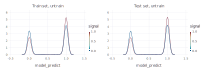

In [10]:
# Dense layer is linear, sigma is identity
# softmax gives you normalized vector (sort of)
m = Chain(Dense(10,2), softmax)

# cross entropy is natual choice for onehot data, since we only have 1 or 0, this is basically -p*log(q)
loss(x, y) = Flux.crossentropy(m(x), y)

# ADAM optimizer https://arxiv.org/abs/1412.6980v8
opt = ADAM(0.001, (0.9, 0.999))

# make two sets for visualization the train model compare before & after
xs_test = convert(Matrix, df_test[1:end,4:13])
df_balanced[:model_predict] = [m(xs_train[i,:]).data[1] for i=1:length(xs_train[:,1])]
df_test[:model_predict] = [m(xs_test[i,:]).data[1] for i=1:length(xs_test[:,1])]
fake_before = plot(df_balanced, x=:model_predict, color=:signal, Guide.Title("Train set, untrain"), Geom.density(bandwidth=0.05))
real_before = plot(df_test, x=:model_predict, Guide.Title("Test set, untrain"), color=:signal, Geom.density(bandwidth=0.05));
set_default_plot_size(8inch, 3inch);
gridstack([fake_before real_before])

In [11]:
# train 4 times over our data
Flux.@epochs 8 Flux.train!(loss, params(m), data, opt)

┌ Info: Epoch 1
└ @ Main /home/akako/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 2
└ @ Main /home/akako/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 3
└ @ Main /home/akako/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 4
└ @ Main /home/akako/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 5
└ @ Main /home/akako/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 6
└ @ Main /home/akako/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 7
└ @ Main /home/akako/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105
┌ Info: Epoch 8
└ @ Main /home/akako/.julia/packages/Flux/zNlBL/src/optimise/train.jl:105


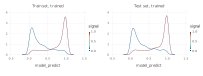

In [12]:
df_balanced[:model_predict] = [m(xs_train[i,:]).data[1] for i=1:length(xs_train[:,1])]
df_test[:model_predict] = [m(xs_test[i,:]).data[1] for i=1:length(xs_test[:,1])]

fake_after = plot(df_balanced, x=:model_predict, color=:signal, Guide.Title("Train set, trained"), Geom.density(bandwidth=0.05))
real_after = plot(df_test, x=:model_predict, color=:signal, Guide.Title("Test set, trained"), Geom.density(bandwidth=0.05))
set_default_plot_size(8inch, 3inch);
gridstack([fake_after real_after])

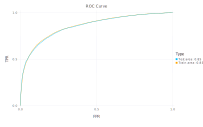

In [13]:
df_AUC = DataFrame()
# https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc
TPR, FPR = [], []
TPR2, FPR2 = [], []
for i=0:0.001:1
    TP  = sum((df_test.signal .== 1.0) .& (df_test.model_predict .> i))
    FP = sum((df_test.signal .== 0.0) .& (df_test.model_predict .> i))
    TN = sum((df_test.signal .== 0.0) .& (df_test.model_predict .< i))
    FN = sum((df_test.signal .== 1.0) .& (df_test.model_predict .< i))
    push!(TPR, TP/(TP+FN))
    push!(FPR, FP/(FP+TN))
    TP2 = sum((df_balanced.signal .== 1.0) .& (df_balanced.model_predict .> i))
    FP2 = sum((df_balanced.signal .== 0.0) .& (df_balanced.model_predict .> i))
    TN2 = sum((df_balanced.signal .== 0.0) .& (df_balanced.model_predict .< i))
    FN2 = sum((df_balanced.signal .== 1.0) .& (df_balanced.model_predict .< i))
    push!(TPR2, TP2/(TP2+FN2))
    push!(FPR2, FP2/(FP2+TN2))
end
df_AUC[:FPR] = FPR
df_AUC[:TPR] = TPR
df_AUC[:FPR2] = FPR2
df_AUC[:TPR2] = TPR2
test_area = reysum(FPR, TPR)
train_area = reysum(FPR2, TPR2)


test_ROC = layer(df_AUC, x=:FPR, y=:TPR, Geom.line)
train_ROC = layer(df_AUC, x=:FPR2, y=:TPR2, Geom.line, Theme(default_color="orange"))
set_default_plot_size(8inch, 5inch)
plot(test_ROC, train_ROC, Guide.Title("ROC Curve"), Guide.manual_color_key("Type", ["Test area: $(test_area)", " Train area: $(train_area)"], ["deepskyblue", "orange"]))